In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib


In [49]:
df=pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [50]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])

df['hour']=df['trans_date_trans_time'].dt.hour
df['day']=df['trans_date_trans_time'].dt.day
df['month']=df['trans_date_trans_time'].dt.month


In [51]:
drp_columns=['Unnamed: 0','trans_date_trans_time','first','last','street','city','state','zip','dob','job','trans_num']
df=df.drop(columns=drp_columns)

In [53]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1


In [54]:
cat_col=['merchant','category','gender']
encoders={}
for col in cat_col:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [55]:
def haversine(lat1,lon1,lat2, lon2):
    return np.array([geodesic((a,b),(c,d)).km for a,b,c,d in zip(lat1,lon1,lat2, lon2)])

df['distance']=haversine(df['lat'],df['long'],df['merch_lat'],df['merch_long'])

In [56]:
df.head()

,cc_num,merchant,category,amt,gender,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,hour,day,month,distance
0,2703186189652095,514,8,4.97,0,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,0,1,1,78.773821
1,630423337322,241,4,107.23,0,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,0,1,1,30.216618
2,38859492057661,390,0,220.11,1,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,0,1,1,108.102912
3,3534093764340240,360,2,45.00,1,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,0,1,1,95.685115
4,375534208663984,297,9,41.96,1,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,0,1,1,77.702395


In [57]:
features=['merchant','category','amt','cc_num','hour','day','month','gender','distance']
x=df[features]
y=df['is_fraud']

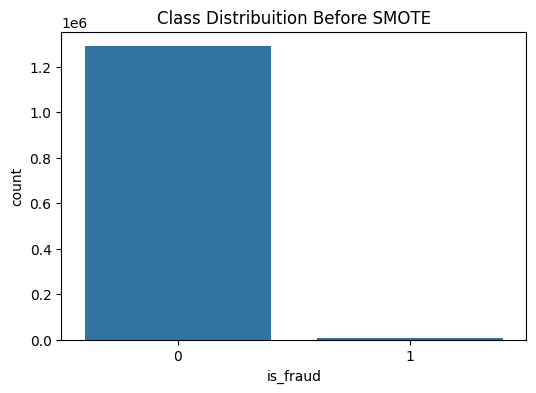

In [58]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud',data=df)
plt.title("Class Distribuition Before SMOTE")
plt.show()

In [59]:
smote=SMOTE(random_state=42)
x_resample,y_resample=smote.fit_resample(x,y)

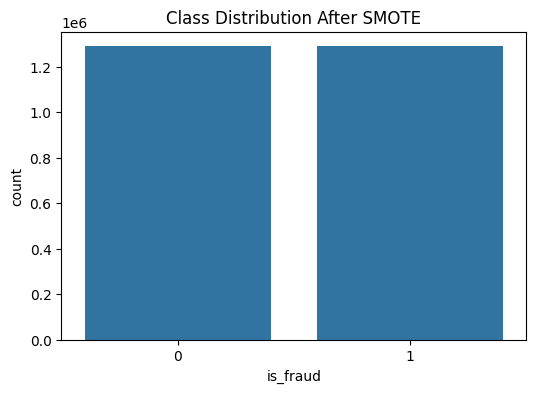

In [60]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

In [61]:
x_train,x_test,y_train,y_test=train_test_split(x_resample,y_resample,test_size=0.2,random_state=42)

In [62]:
lgb_model=lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metrics='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=1,
    n_estimators=200
)
lgb_model.fit(x_train,y_train)

[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(is_unbalance=True, learning_rate=0.05, max_depth=1,
               metrics='auc', n_estimators=200, objective='binary')

In [63]:
y_pred=lgb_model.predict(x_test)

In [64]:
print("classification_report:\n", classification_report(y_test,y_pred))
print("Roc AUC Score: ", roc_auc_score(y_test,y_pred))

classification_report:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88    257186
           1       0.95      0.79      0.86    258482

    accuracy                           0.87    515668
   macro avg       0.88      0.87      0.87    515668
weighted avg       0.88      0.87      0.87    515668

Roc AUC Score:  0.8705875259208415


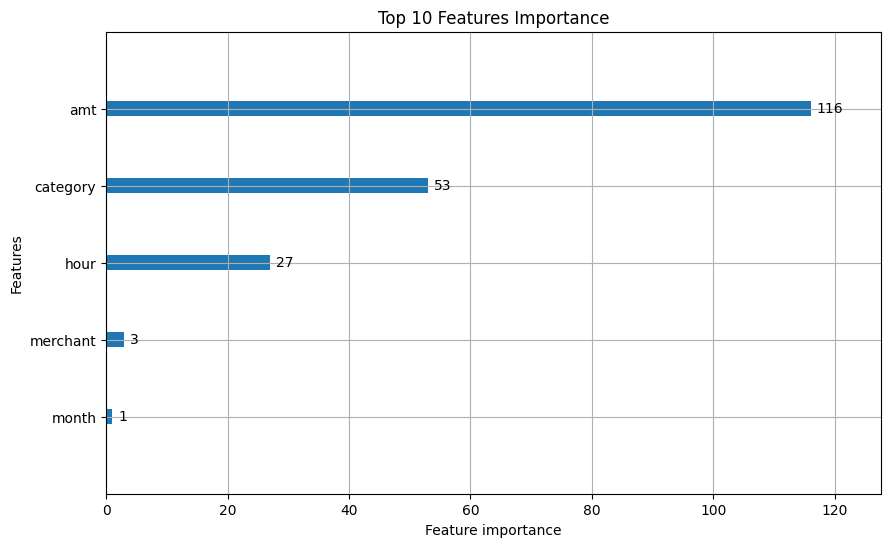

In [65]:
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split', figsize=(10,6))
plt.title("Top 10 Features Importance")
plt.show()

In [67]:
fpr, tpr, thresholds = roc_curve(y_test, lgb_model.predict_proba(x_test)[:, 1])
roc_auc = auc(fpr, tpr)

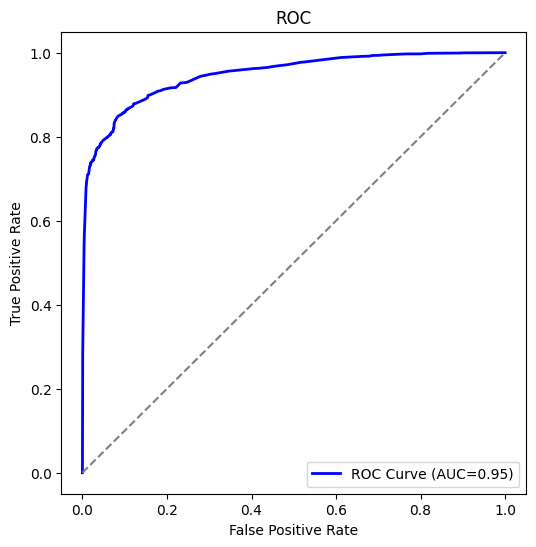

In [68]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1], color='gray', linestyle='--')
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [70]:
joblib.dump(lgb_model, "fraud_detection_model.jb")
joblib.dump(encoders, "label_encoder.jb")

['label_encoder.jb']